# Series de Tiempo

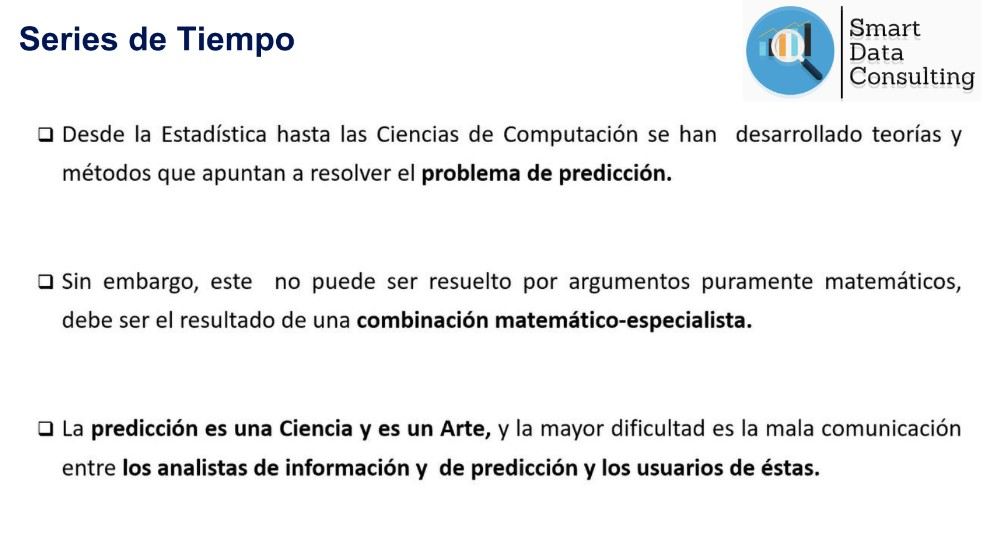

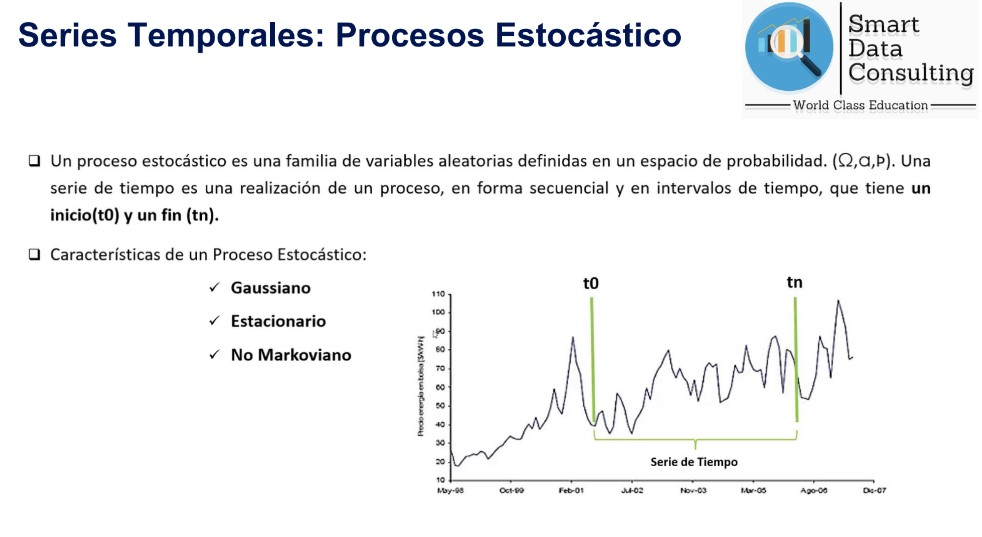

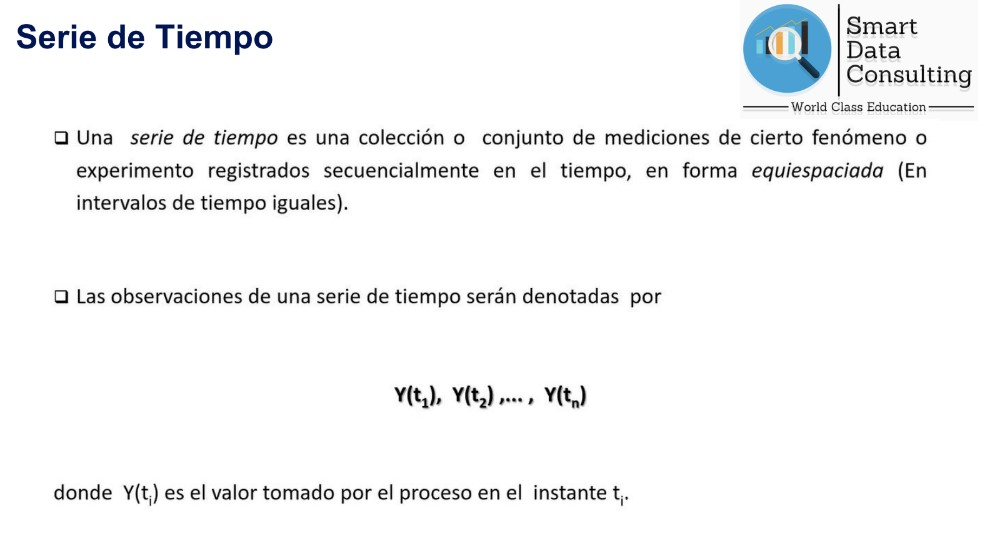

Ejemplo de una red neuronal multicapa en Keras para hacer forecasting (predicción de valores futuros) utilizando el conjunto de datos de consumo eléctrico de la ciudad de Nueva York.

Primero, importamos las bibliotecas necesarias y cargamos el conjunto de datos desde la URL en líne

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
df = pd.read_csv(url, header=0,
                 parse_dates=[0]# detecta columnas texto en formato fecha y convierte a fecha
                 , index_col=0 # convierte primera columna en indice
                 )#,squeeze = True) # convierte los datos de pandas en una serie (solo deben tener una columna)

In [ ]:
df.shape

In [ ]:
df.head(10)

# SERIES DE TIEMPO

In [ ]:
# Graficar la serie temporal
df.plot(figsize=(12, 6))
plt.title('Daily Minimum Temperatures')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.show()

## Series de Tiempo (Estadistica Clasica)

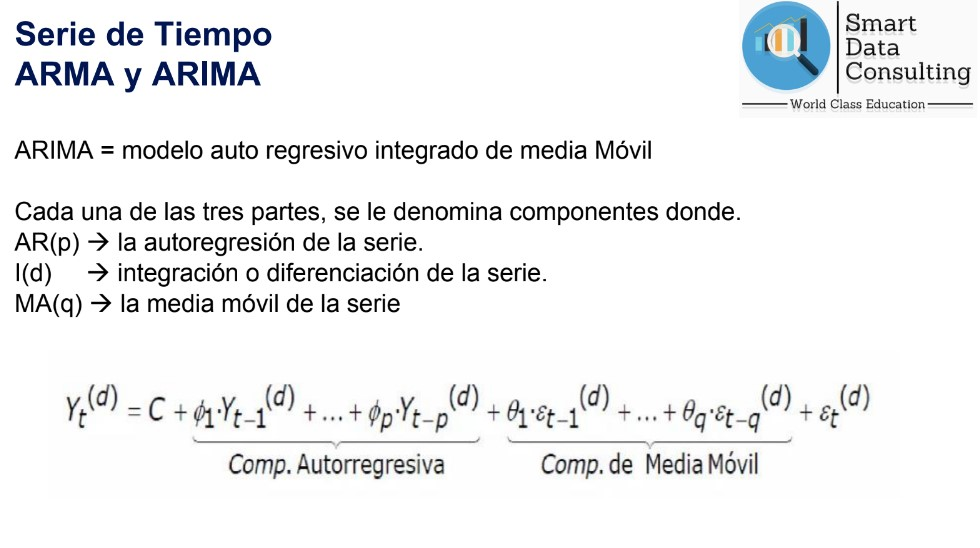

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Prueba de Dickey-Fuller aumentada para verificar la estacionaridad
result = adfuller(df['Temp'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [ ]:
# Si p-value > 0.05, diferenciamos los datos
if result[1] > 0.05:
    df_diff = df.diff().dropna()
else:
    df_diff = df

In [ ]:
# Graficar ACF y PACF
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
plot_acf(df_diff, ax=axes[0])
axes[0].set_title('Autocorrelograma (ACF)')
plot_pacf(df_diff, ax=axes[1])
axes[1].set_title('Autocorrelograma Parcial (PACF)')
plt.show()

Las gráficas de ACF y PACF nos ayudarán a identificar los parámetros
𝑝
p y
𝑞
q para el modelo ARIMA:

- ACF (Autocorrelation Function): Observa cuántos lags (retardos) son significativos. Si el ACF disminuye gradualmente o muestra una estructura cíclica, puede sugerir la presencia de un componente AR (Autoregressive).

- PACF (Partial Autocorrelation Function): Observa los primeros lags significativos. Si el PACF muestra una caída abrupta después de un cierto lag, puede sugerir el orden
𝑝
p del componente AR.

## Ajustamos modelo ARIMA

In [ ]:
# Ajustar el modelo ARIMA
model_arima = ARIMA(df_diff, order=(4,0,3)) # Ajusta el orden según sea necesario
fit_arima = model_arima.fit()
print(fit_arima.summary())

In [ ]:
# Graficar los residuos
fit_arima.resid.plot(figsize=(12, 6))
plt.title('ARIMA Residuals')
plt.show()

## Ajustamos modelo SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar el modelo SARIMA
model_sarima = SARIMAX(df, order=(4,0,3), seasonal_order=(1,1,1,12)) # Ajusta los parámetros según sea necesario
fit_sarima = model_sarima.fit(disp=False)
print(fit_sarima.summary())

# Graficar los residuos
fit_sarima.resid.plot(figsize=(12, 6))
plt.title('SARIMA Residuals')
plt.show()


# Ajustamos el Modelo Prophet

In [ ]:
df.head(2)

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
# Preparar los datos para Prophet
df = df.reset_index()
df.columns = ['ds', 'y']

# Ajustar el modelo Prophet
model_prophet = Prophet()
model_prophet.fit(df)

# Hacer una predicción
future = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(future)

# Graficar la predicción
model_prophet.plot(forecast)
plt.title('Prophet Forecast')
plt.show()

# Mostrar los componentes de la predicción
model_prophet.plot_components(forecast)
plt.show()


## Evaluamos los resultados de los Modelos

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Predicciones del modelo ARIMA
pred_arima = fit_arima.predict(start=0, end=len(df)-1, dynamic=False)

# Predicciones del modelo SARIMA
pred_sarima = fit_sarima.fittedvalues

# Predicciones del modelo Prophet
#forecast = forecast.set_index('ds')
pred_prophet = forecast['yhat'][:len(df)]

# Calcular RMSE
rmse_arima = np.sqrt(mean_squared_error(df['y'], pred_arima))
rmse_sarima = np.sqrt(mean_squared_error(df['y'], pred_sarima))
rmse_prophet = np.sqrt(mean_squared_error(df['y'], pred_prophet))

# Calcular MAPE
mape_arima = mean_absolute_percentage_error(df['y'], pred_arima)
mape_sarima = mean_absolute_percentage_error(df['y'], pred_sarima)
mape_prophet = mean_absolute_percentage_error(df['y'], pred_prophet)

print('RMSE ARIMA:', rmse_arima)
print('MAPE ARIMA:', mape_arima)

print('RMSE SARIMA:', rmse_sarima)
print('MAPE SARIMA:', mape_sarima)

print('RMSE Prophet:', rmse_prophet)
print('MAPE Prophet:', mape_prophet)


# RED NEURONAL

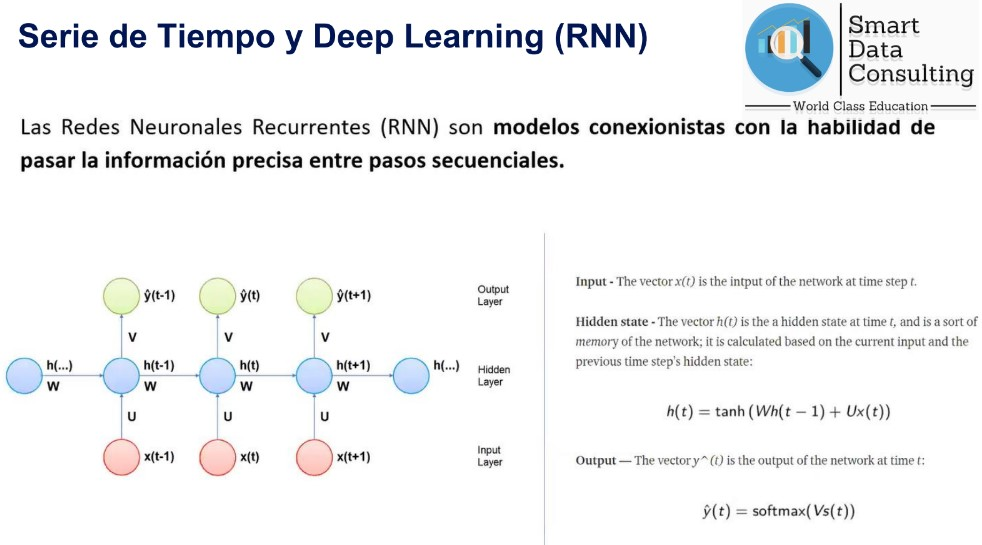

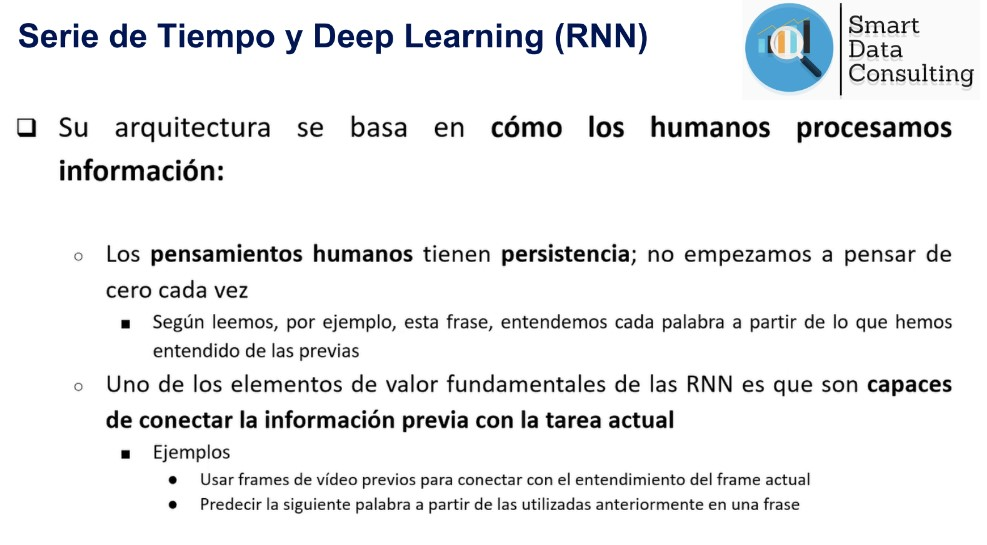

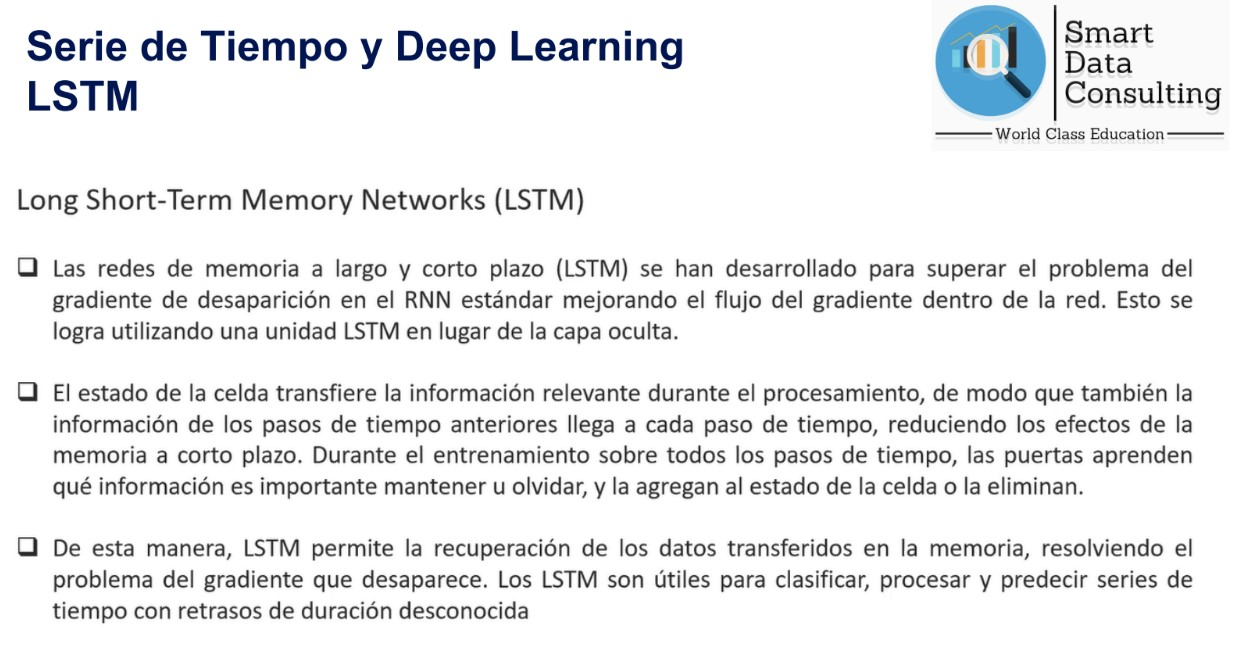

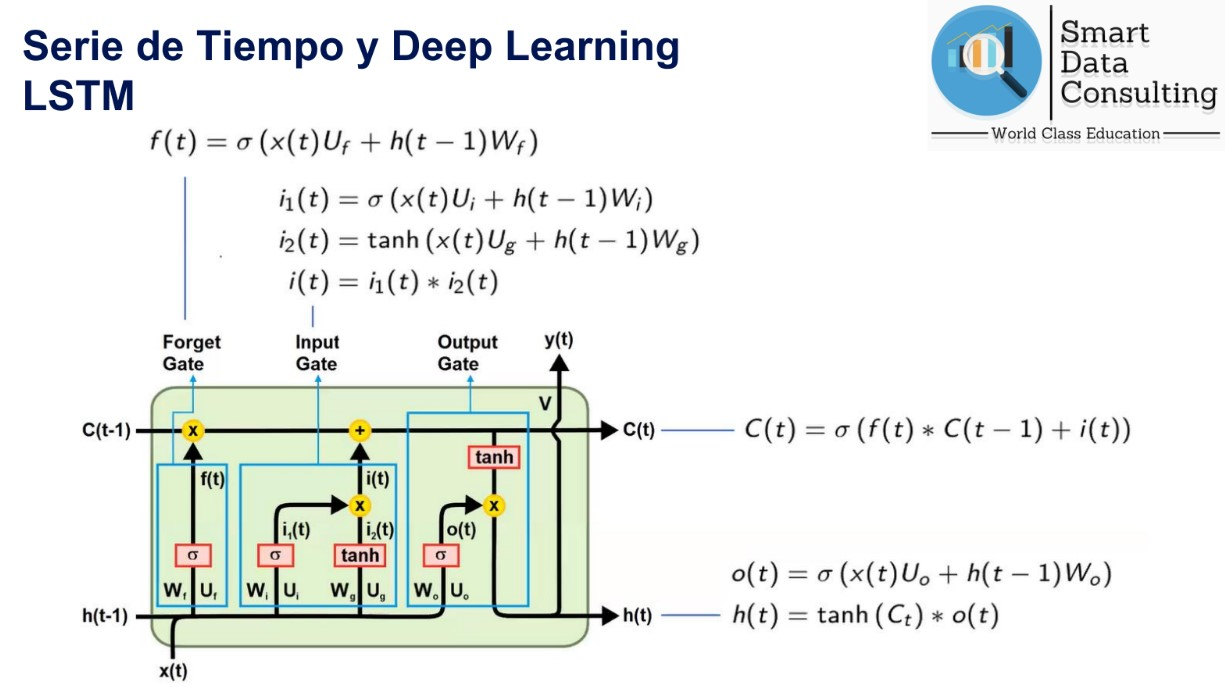

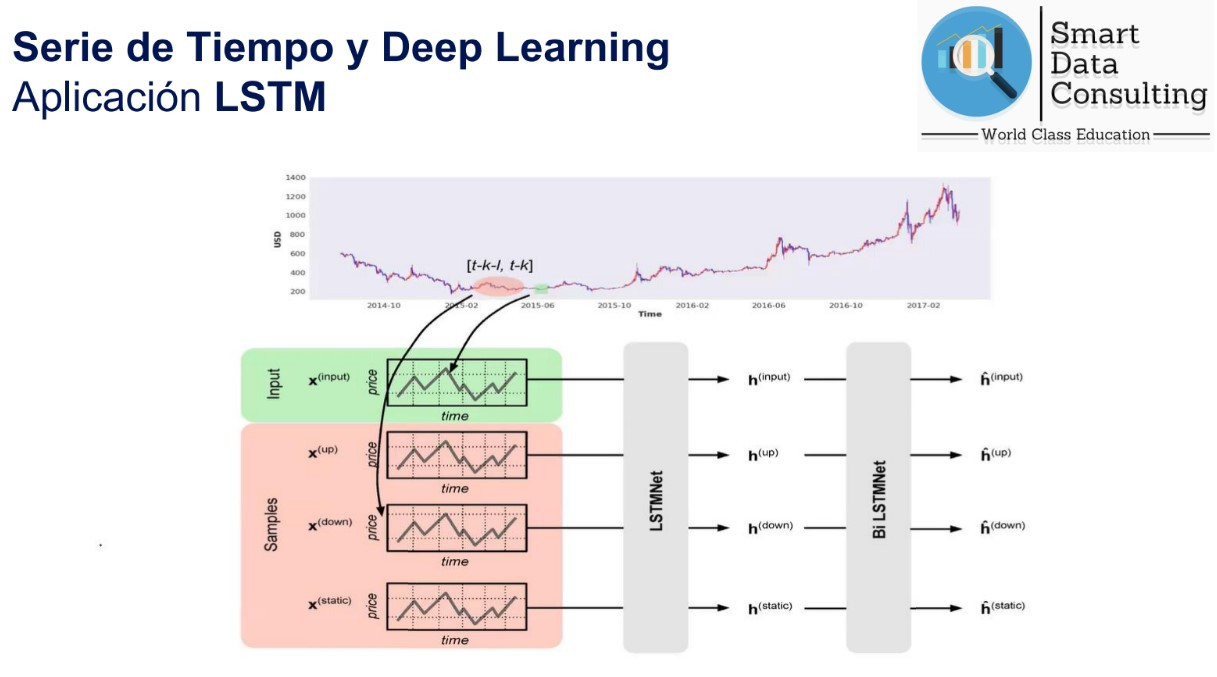

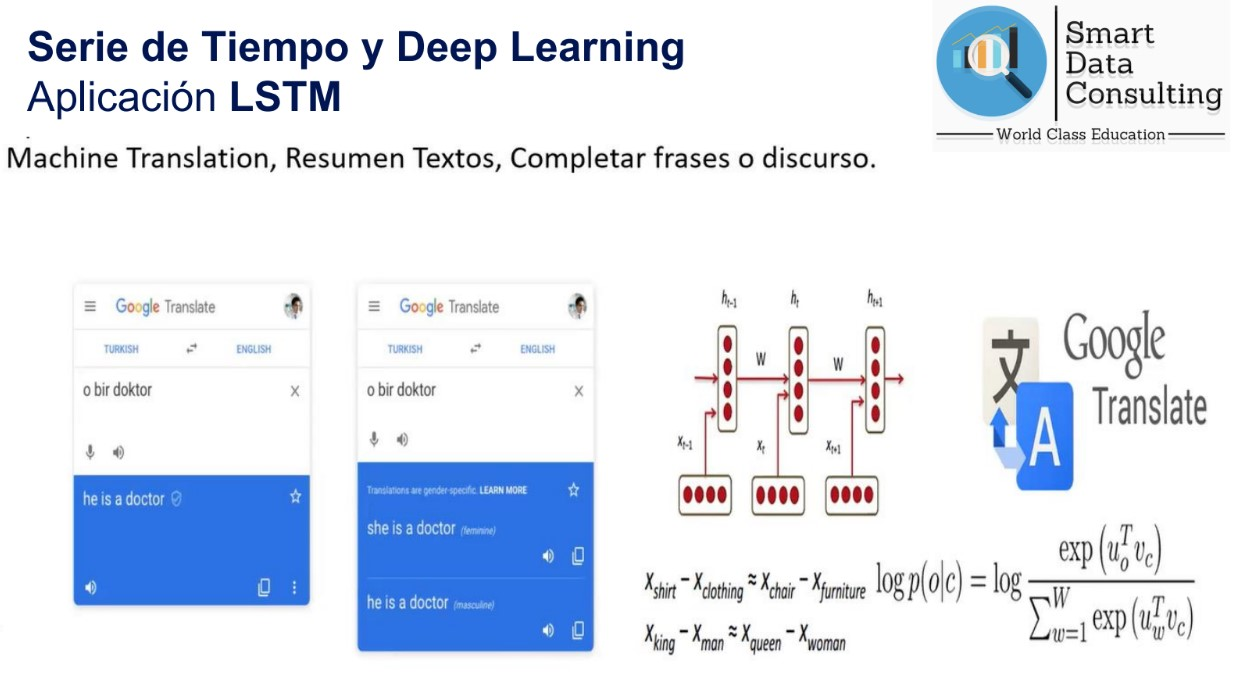

Luego, transformamos los datos para que estén en el formato adecuado para el modelado. En este caso, utilizaremos un enfoque de ventana deslizante para crear secuencias de longitud fija de datos de entrada y salida. Esto implica crear una matriz de características X y una matriz de objetivos y, donde cada fila en X contiene una secuencia de observaciones pasadas y cada valor correspondiente en y es la observación siguiente en la serie temporal:

La sintaxis "data.reshape(-1, 1)" indica que se desea cambiar la forma de la matriz "data" a una columna unidimensional, es decir, se quiere convertir los datos en un arreglo de una sola columna. El parámetro "-1" en el primer argumento de la función reshape indica que se debe inferir automáticamente el tamaño necesario en esa dimensión para que los datos encajen correctamente. La dimensión "1" en el segundo argumento indica que se quiere una sola columna.

In [ ]:
data = df.values
data.reshape(-1,1).shape

In [ ]:
data = df.values
print(data.reshape(-1, 1),df.values)
print(data.reshape(-1, 1).shape,df.values.shape)

In [ ]:
# convertimos a una matriz de valores
data = df.values
data = data.reshape(-1, 1)
# dividimos los datos en conjuntos de entrenamiento y prueba
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

# normalizamos los datos
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
# creamos las secuencias de entrada y salida
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)
seq_length = 7
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

In [ ]:
train[1:8,0] , test[0,0]

In [ ]:
X_train, y_train

A continuación, definimos el modelo de red neuronal utilizando la API secuencial de Keras. Este modelo tendrá tres capas: una capa de entrada, una capa oculta y una capa de salida. La capa oculta utiliza la función de activación ReLU y la capa de salida utiliza la función de activación lineal, ya que estamos realizando una tarea de regresión:

In [ ]:
seq_length

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(seq_length,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='linear')
])

Compilamos el modelo especificando la función de pérdida y el optimizador a utilizar durante el entrenamiento:

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')#binary cross entropy

Finalmente, ajustamos el modelo a los datos de entrenamiento y evaluamos su rendimiento en los datos de prueba:

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=2)

Podemos utilizar el modelo entrenado para hacer predicciones en nuevos datos de entrada utilizando el método predict():

In [ ]:
# hacemos predicciones en los datos de prueba
y_pred = model.predict(X_test)
# invertimos la normalización de los datos
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
plt.plot(y_test_inv, label='Valor real')
plt.plot(y_pred, label='Predicción')
plt.legend()
plt.show()

In [ ]:
# Utilizar el modelo para hacer predicciones
predictions = model.predict(X_test)

In [ ]:
print(predictions)

Finalmente veremos el error del modelo

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Calcular las predicciones para los datos de entrenamiento y prueba
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calcular el MSE para los datos de entrenamiento y prueba
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

# Calcular el R2 para los datos de entrenamiento y prueba
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Imprimir los resultados
print('MSE (train): {:.4f}'.format(mse_train))
print('MSE (test): {:.4f}'.format(mse_test))
print('R2 (train): {:.4f}'.format(r2_train))
print('R2 (test): {:.4f}'.format(r2_test))

Ahora Procederemos a guardar el modelo

In [ ]:
import pickle

# Guardar el modelo en un archivo con pickle
with open('rn_64_32_1.model', 'wb') as f:
    pickle.dump(model, f)

# Cargar el modelo desde el archivo con pickle
with open('rn_64_32_1.model', 'rb') as f:
    loaded_model = pickle.load(f)